In [110]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from netCDF4 import Dataset
import glob
import gsw
import pandas as pd
import scipy.io as si
import pickle
from scipy.optimize import fmin
from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec
# functions I've written
from glider_cross_section import Glider
from mode_decompositions import vertical_modes, vertical_modes_f, PE_Tide_GM
from toolkit import spectrum_fit, plot_pro, find_nearest

# -------------------------------------------------------------------------------------------------------------------
# --- BATHYMETRY
bath = '/Users/jake/Desktop/abaco/abaco_bathymetry/GEBCO_2014_2D_-79.275_22.25_-67.975_29.1.nc'
bath_fid = Dataset(bath, 'r')
bath_lon = bath_fid['lon'][:]
bath_lat = bath_fid['lat'][:]
bath_z = bath_fid['elevation'][:]
# -------------------------------------------------------------------------------------------------
# USING GLIDER PACKAGE
gs_37 = 45
ge_37 = 80
x37 = Glider(37, np.arange(gs_37, ge_37), '/Users/jake/Documents/baroclinic_modes/DG/ABACO_2017/sg037')
gs_38 = 50
ge_38 = 80
x38 = Glider(38, np.arange(gs_38, ge_38), '/Users/jake/Documents/baroclinic_modes/DG/ABACO_2017/sg038')
gs_39 = 20
ge_39 = 90
x39 = Glider(39, np.arange(gs_39, ge_39), '/Users/jake/Documents/baroclinic_modes/DG/ABACO_2018/sg039')

I loaded in the data

In [111]:
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg037_2017_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 471
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs_37:
    first = 0
else:
    first = np.where(profile_tags < gs_37)[0][-1] + 1
if profile_tags[-1] == ge_37 - 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge_37)[0][0] - 1
d_in = range(first, last)

profile_tags_37 = profile_tags[d_in]
neutral_density_37 = dg_data['Neut_den'][0][0][0:limm, d_in]
t_37 = dg_data['Temp'][0][0][0:limm, d_in]
s_37 = dg_data['Sal'][0][0][0:limm, d_in]
lon_37 = dg_data['Lon'][0][0][0:limm, d_in]
lat_37 = dg_data['Lat'][0][0][0:limm, d_in]
dac_u_37 = dg_data['Dac_u'][0][0][0][d_in]
dac_v_37 = dg_data['Dac_v'][0][0][0][d_in]
d_time_37 = dg_data['Time'][0][0][0:limm, d_in] - 366
ref_lat_37 = np.nanmean(lat_37)
time_rec_bin_37 = np.nanmean(d_time_37, axis=0)
grid_37 = dg_data['Depth'][0][0][0:limm, 0]
grid_p_37 = gsw.p_from_z(-1 * grid_37, ref_lat_37)
z_37 = -1 * grid_37
sz_g_37 = grid_37.shape[0]

# Compute density
sa_37, ct_37, theta_37, sig0_37, sig2_37, dg_N2_37 = x37.density(grid_37, ref_lat_37, t_37, s_37, lon_37, lat_37)

In [4]:
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg038_2017_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 471
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs_38:
    first = 0
else:
    first = np.where(profile_tags < gs_38)[0][-1] + 1
if profile_tags[-1] == ge_38 - 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge_38)[0][0] - 1
d_in = range(first, last)

profile_tags_38 = profile_tags[d_in]
neutral_density_38 = dg_data['Neut_den'][0][0][0:limm, d_in]
t_38 = dg_data['Temp'][0][0][0:limm, d_in]
s_38 = dg_data['Sal'][0][0][0:limm, d_in]
lon_38 = dg_data['Lon'][0][0][0:limm, d_in]
lat_38 = dg_data['Lat'][0][0][0:limm, d_in]
dac_u_38 = dg_data['Dac_u'][0][0][0][d_in]
dac_v_38 = dg_data['Dac_v'][0][0][0][d_in]
d_time_38 = dg_data['Time'][0][0][0:limm, d_in] - 366
ref_lat_38 = np.nanmean(lat_38)
time_rec_bin_38 = np.nanmean(d_time_38, axis=0)
grid_38 = dg_data['Depth'][0][0][0:limm, 0]
grid_p_38 = gsw.p_from_z(-1 * grid_38, ref_lat_38)
z_38 = -1 * grid_38
sz_g_38 = grid_38.shape[0]

# Compute density
sa_38, ct_38, theta_38, sig0_38, sig2_38, dg_N2_38 = x38.density(grid_38, ref_lat_38, t_38, s_38, lon_38, lat_38)

In [5]:
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg039_2018_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 471
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs_39:
    first = 0
else:
    first = np.where(profile_tags < gs_39)[0][-1] + 1
if profile_tags[-1] == ge_39 - 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge_39)[0][0] - 1
d_in = range(first, last)

profile_tags_39 = profile_tags[d_in]
neutral_density_39 = dg_data['Neut_den'][0][0][0:limm, d_in]
t_39 = dg_data['Temp'][0][0][0:limm, d_in]
s_39 = dg_data['Sal'][0][0][0:limm, d_in]
lon_39 = dg_data['Lon'][0][0][0:limm, d_in]
lat_39 = dg_data['Lat'][0][0][0:limm, d_in]
dac_u_39 = dg_data['Dac_u'][0][0][0][d_in]
dac_v_39 = dg_data['Dac_v'][0][0][0][d_in]
d_time_39 = dg_data['Time'][0][0][0:limm, d_in] - 366
ref_lat_39 = np.nanmean(lat_39)
time_rec_bin_39 = np.nanmean(d_time_39, axis=0)
grid_39 = dg_data['Depth'][0][0][0:limm, 0]
grid_p_39 = gsw.p_from_z(-1 * grid_39, ref_lat_39)
z_39 = -1 * grid_39
sz_g_39 = grid_39.shape[0]

In [6]:
# --- LOAD ABACO SHIPBOARD CTD DATA
ship_files = glob.glob('/Users/jake/Documents/baroclinic_modes/SHIPBOARD/ABACO/ship_ladcp*.pkl')
# all shipboard casts
for i in range(len(ship_files)):
    pkl_file = open(ship_files[i], 'rb')
    abaco_ship = pickle.load(pkl_file)
    pkl_file.close()
    if i < 1:
        time_key = np.int(ship_files[i][-14:-10]) * np.ones(abaco_ship['oxygen'].shape[1])
        ship_o2_1 = abaco_ship['oxygen']
        ship_SA = abaco_ship['SA']
        ship_CT = abaco_ship['CT']
        ship_sig0 = abaco_ship['den_grid']
        ship_dist = abaco_ship['den_dist']
        ship_lon = abaco_ship['cast_lon']
        ship_lat = abaco_ship['cast_lat']
        adcp_depth = abaco_ship['adcp_depth']
        adcp_dist = abaco_ship['adcp_dist']
        adcp_v = abaco_ship['adcp_v']
        adcp_time = abaco_ship['time_uv']
    else:
        time_key = np.concatenate((time_key, np.int(ship_files[i][-14:-10]) * np.ones(abaco_ship['oxygen'].shape[1])))
        ship_o2_1 = np.concatenate((ship_o2_1, abaco_ship['oxygen']), axis=1)
        ship_SA = np.concatenate((ship_SA, abaco_ship['SA']), axis=1)
        ship_CT = np.concatenate((ship_CT, abaco_ship['CT']), axis=1)
        ship_sig0 = np.concatenate((ship_sig0, abaco_ship['den_grid']), axis=1)
        ship_dist = np.concatenate((ship_dist, abaco_ship['den_dist']))
        ship_lon = np.concatenate((ship_lon, abaco_ship['cast_lon']))
        ship_lat = np.concatenate((ship_lat, abaco_ship['cast_lat']))
        adcp_dist = np.concatenate((adcp_dist, abaco_ship['adcp_dist']))
        adcp_v = np.concatenate((adcp_v, abaco_ship['adcp_v']), axis=1)
        adcp_time = np.concatenate((adcp_time, abaco_ship['time_uv']))

ship_depth_0 = abaco_ship['bin_depth']
ship_depth = np.repeat(np.transpose(np.array([abaco_ship['bin_depth']])), np.shape(ship_sig0)[1], axis=1)

pkl_file = open('/Users/jake/Documents/baroclinic_modes/SHIPBOARD/ABACO/no_ctd_ship_ladcp_2018-02-25.pkl', 'rb')
abaco_ship = pickle.load(pkl_file)
pkl_file.close()
adcp_dist = np.concatenate((adcp_dist, abaco_ship['adcp_dist']))
adcp_v = np.concatenate((adcp_v, abaco_ship['adcp_v']), axis=1)
adcp_time = np.concatenate((adcp_time, abaco_ship['time_uv']))

# --------
# single year analysis
pkl_file = open('/Users/jake/Documents/baroclinic_modes/SHIPBOARD/ABACO/ship_ladcp_2017-05-08.pkl', 'rb')
abaco_ship = pickle.load(pkl_file)
pkl_file.close()
this_ship_sig0 = abaco_ship['den_grid']
this_ship_CT = abaco_ship['CT']
this_ship_SA = abaco_ship['SA']
this_ship_dist = abaco_ship['den_dist']
this_ship_depth_0 = abaco_ship['bin_depth']
this_ship_depth = np.repeat(np.transpose(np.array([abaco_ship['bin_depth']])), np.shape(ship_sig0)[1], axis=1)
# pkl_file = open('/Users/jake/Documents/baroclinic_modes/SHIPBOARD/ABACO/no_ctd_ship_ladcp_2018-02-25.pkl', 'rb')
# abaco_ship = pickle.load(pkl_file)
# pkl_file.close()
this_adcp_dist = abaco_ship['adcp_dist']
this_adcp_depth = abaco_ship['adcp_depth']
this_adcp_v = abaco_ship['adcp_v']

In [33]:
# load 2017 LADCP and CTD with neutral density calculated 
ship17 = '/Users/jake/Documents/baroclinic_modes/Shipboard/ABACO/ship_ladcp_2017.nc'
ship17_fid = Dataset(ship17, 'r')
ship17_gamma = ship17_fid['gamma'][:]
ship17_dist = ship17_fid['dist'][:]
ship17_dep = ship17_fid['depth'][:]
ship17_uv_dist = ship17_fid['dist_uv'][:]
ship17_u = ship17_fid['adcp_u'][:, ship17_uv_dist < 400] / 100.
ship17_v = ship17_fid['adcp_v'][:, ship17_uv_dist < 400] / 100.
ship17_uv_dep = ship17_fid['dep_uv']

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


In [32]:
np.shape(ship17_v)

(550, 21)

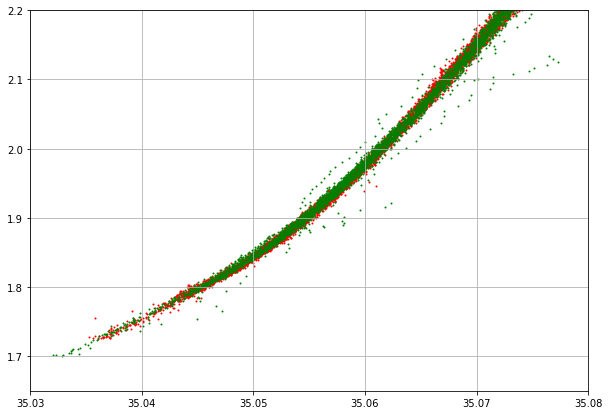

()

In [113]:
tt = [ct_37, ct_38, t_39]
ss = [sa_37, sa_38, s_39]
cg = ['r', 'g', 'b']
f, ax = plt.subplots()
for i in range(2):
    for j in range(np.shape(tt[i])[1]):
        ax.scatter(ss[i][:, j], tt[i][:, j], s=1, color=cg[i])
# for i in range(np.shape(this_ship_CT)[1]):
#     ax.scatter(this_ship_SA[:, i], this_ship_CT[:, i], s=1, color='k')
ax.set_xlim([35.03, 35.08])
ax.set_ylim([1.65, 2.2])
# ax.set_xlim([35, 35.5])
# ax.set_ylim([1.65, 10])
plot_pro(ax)

In [9]:
# compute M/W sections and compute velocity
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])

In [115]:
# SG037
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x37.transect_cross_section_1(grid_37, 
                                                                                                neutral_density_37,
                                                                                                ct_37, sa_37,
                                                                                                lon_37, lat_37,
                                                                                                dac_u_37, dac_v_37,
                                                                                                profile_tags_37,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2017_transects_gamma.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2017_transects_gamma.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0_37 = DACe_MW[0][0:-1].copy()
dacn_mw_0_37 = DACn_MW[0][0:-1].copy()
dg_v_0_37 = v_g[0][:, 0:-1].copy()
dg_v_e_0_37 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0_37 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep_37 = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep_37 = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep_37 = avg_sa_per_dep_0[0].copy()
dg_v_lon_0_37 = mwe_lon[0][0:-1].copy()
dg_v_lat_0_37 = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0_37 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0_37 = np.concatenate((dace_mw_0_37, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0_37 = np.concatenate((dacn_mw_0_37, DACn_MW[i][0:-1]), axis=0)
    dg_v_0_37 = np.concatenate((dg_v_0_37, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0_37 = np.concatenate((dg_v_e_0_37, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0_37 = np.concatenate((dg_v_n_0_37, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep_37 = np.concatenate((avg_ct_per_dep_37, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep_37 = np.concatenate((avg_sa_per_dep_37, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep_37 = np.concatenate((avg_sig0_per_dep_37, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon_0_37 = np.concatenate((dg_v_lon_0_37, mwe_lon[i][0:-1]))
    dg_v_lat_0_37 = np.concatenate((dg_v_lat_0_37, mwe_lat[i][0:-1]))
    dg_v_dive_no_0_37 = np.concatenate((dg_v_dive_no_0_37, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin_37[np.in1d(profile_tags_37, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0_37 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0_37 = np.concatenate((dg_mw_time_0_37, np.array([np.nanmean(tin)])))
        count = count + 1

prof_lon_i_37 = np.nanmean(lon_37, axis=0)
prof_lat_i_37 = np.nanmean(lat_37, axis=0)       


In [11]:
# SG038
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x38.transect_cross_section_1(grid_38, 
                                                                                                neutral_density_38,
                                                                                                ct_38, sa_38,
                                                                                                lon_38, lat_38,
                                                                                                dac_u_38, dac_v_38,
                                                                                                profile_tags_38,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg038_2017_transects_gamma.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg038_2017_transects_gamma.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0_38 = DACe_MW[0][0:-1].copy()
dacn_mw_0_38 = DACn_MW[0][0:-1].copy()
dg_v_0_38 = v_g[0][:, 0:-1].copy()
dg_v_e_0_38 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0_38 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep_38 = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep_38 = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep_38 = avg_sa_per_dep_0[0].copy()
dg_v_lon_0_38 = mwe_lon[0][0:-1].copy()
dg_v_lat_0_38 = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0_38 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0_38 = np.concatenate((dace_mw_0_38, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0_38 = np.concatenate((dacn_mw_0_38, DACn_MW[i][0:-1]), axis=0)
    dg_v_0_38 = np.concatenate((dg_v_0_38, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0_38 = np.concatenate((dg_v_e_0_38, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0_38 = np.concatenate((dg_v_n_0_38, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep_38 = np.concatenate((avg_ct_per_dep_38, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep_38 = np.concatenate((avg_sa_per_dep_38, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep_38 = np.concatenate((avg_sig0_per_dep_38, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon_0_38 = np.concatenate((dg_v_lon_0_38, mwe_lon[i][0:-1]))
    dg_v_lat_0_38 = np.concatenate((dg_v_lat_0_38, mwe_lat[i][0:-1]))
    dg_v_dive_no_0_38 = np.concatenate((dg_v_dive_no_0_38, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin_38[np.in1d(profile_tags_38, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0_38 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0_38 = np.concatenate((dg_mw_time_0_38, np.array([np.nanmean(tin)])))
        count = count + 1

prof_lon_i_38 = np.nanmean(lon_37, axis=0)
prof_lat_i_38 = np.nanmean(lat_37, axis=0)     

In [116]:
lat_in = 26.5
lon_in = -77
dist_grid_s = np.arange(2, 125, 0.005)
dist_grid = np.arange(20, 320, 10)

dist_37 = (lon_37 - lon_in) * (1852 * 60 * np.cos(np.deg2rad(26.5))) / 1000
# eta / v profiles after M/W technique applied
dg_v_dist_37 = (dg_v_lon_0_37 - lon_in) * (1852 * 60 * np.cos(np.deg2rad(26.5))) / 1000

dist_38 = (lon_38 - lon_in) * (1852 * 60 * np.cos(np.deg2rad(26.5))) / 1000
# eta / v profiles after M/W technique applied
dg_v_dist_38 = (dg_v_lon_0_38 - lon_in) * (1852 * 60 * np.cos(np.deg2rad(26.5))) / 1000

# ---------------------------------------------------------------------------------------------------------
# USING GLIDER PROFILES COMPUTE AVERATE T/S/RHO AT INCREASING EASTWARD DISTANCE
count = 0
# uses glider profiles that have not been processed as M/W
mean_dist_37 = np.nanmean(dist_37, 0)
profs_per_avg_37 = np.zeros(np.shape(dist_grid))
CT_avg_grid_37 = np.zeros([np.size(grid_37), np.size(dist_grid)])
SA_avg_grid_37 = np.zeros([np.size(grid_37), np.size(dist_grid)])
sigma_avg_grid_37 = np.zeros([np.size(grid_37), np.size(dist_grid)])
for i in dist_grid:
    mask = (mean_dist_37 > i - 10) & (mean_dist_37 < i + 10)
    profs_per_avg_37[count] = np.sum(mask)
    CT_avg_grid_37[:, count] = np.nanmean(ct_37[:, mask], 1)  
    SA_avg_grid_37[:, count] = np.nanmean(sa_37[:, mask], 1)  
    sigma_avg_grid_37[:, count] = np.nanmean(neutral_density_37[:, mask], 1)  
    count = count + 1
    
count = 0
# uses glider profiles that have not been processed as M/W
mean_dist_38 = np.nanmean(dist_38, 0)
profs_per_avg_38 = np.zeros(np.shape(dist_grid))
CT_avg_grid_38 = np.zeros([np.size(grid_37), np.size(dist_grid)])
SA_avg_grid_38 = np.zeros([np.size(grid_37), np.size(dist_grid)])
sigma_avg_grid_38 = np.zeros([np.size(grid_37), np.size(dist_grid)])
for i in dist_grid:
    mask = (mean_dist_38 > i - 10) & (mean_dist_38 < i + 10)
    profs_per_avg_38[count] = np.sum(mask)
    CT_avg_grid_38[:, count] = np.nanmean(ct_38[:, mask], 1) 
    SA_avg_grid_38[:, count] = np.nanmean(sa_38[:, mask], 1)  
    sigma_avg_grid_38[:, count] = np.nanmean(neutral_density_38[:, mask], 1)  
    count = count + 1    
    

sigma_avg_grid = sigma_avg_grid_38.copy()
sigma_avg_grid[:, 0:15] = 0.5 * (sigma_avg_grid_37[:, 0:15] + sigma_avg_grid_38[:, 0:15])
CT_avg_grid = CT_avg_grid_38.copy()
CT_avg_grid[:, 0:15] = 0.5 * (CT_avg_grid_37[:, 0:15] + CT_avg_grid_38[:, 0:15])
SA_avg_grid = SA_avg_grid_38.copy()
SA_avg_grid[:, 0:15] = 0.5 * (SA_avg_grid_37[:, 0:15] + SA_avg_grid_38[:, 0:15])
    

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: Mean of empty slice


In [37]:
np.shape(grid_38)

(471,)

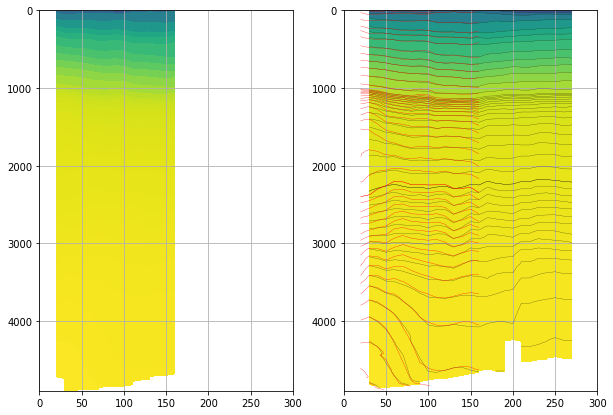

In [124]:
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.2, 0.01)])

matplotlib.rcParams['figure.figsize'] = (10,7)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.contourf(dist_grid, grid_37, sigma_avg_grid_37, levels=sigth_levels)
ax1.invert_yaxis()
ax2.contourf(dist_grid, grid_38, sigma_avg_grid, levels=sigth_levels)
ax2.contour(dist_grid, grid_38, sigma_avg_grid, levels=sigth_levels, colors='k', linewidths=0.2)
ax2.contour(dist_grid, grid_37, sigma_avg_grid_37, levels=sigth_levels, colors='r', linewidths=0.3)
# ax2.contour(ship17_dist, ship17_dep, ship17_gamma, levels=sigth_levels, colors='b', linewidths=0.2)
ax1.set_xlim([0, 300])
ax2.set_xlim([0, 300])
ax2.invert_yaxis()
ax1.grid()
plot_pro(ax2)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/abaco_17_den_cross.jpg", dpi=300)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice


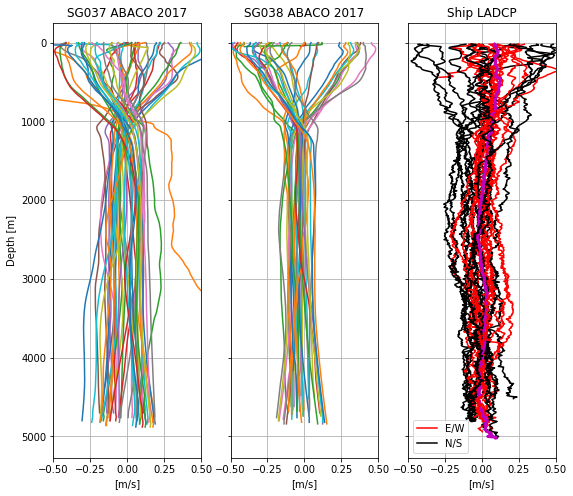

In [159]:
matplotlib.rcParams['figure.figsize'] = (9,8)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
for i in range(np.shape(dg_v_0_37)[1]):
    ax1.plot(dg_v_0_37[:, i], grid_37)
for i in range(np.shape(dg_v_0_38)[1]):
    ax2.plot(dg_v_0_38[:, i], grid_38)   
for i in range(np.shape(ship17_u)[1]):
    ax3.plot(ship17_u[:, i], ship17_uv_dep, color='r')
    ax3.plot(ship17_v[:, i], ship17_uv_dep, color='k') 
ax3.plot(np.nanmean(ship17_u, axis=1), ship17_uv_dep, color='m', linewidth=3)   
ax3.plot(ship17_u[:, i], ship17_uv_dep, color='r', label='E/W')    
ax3.plot(ship17_v[:, i], ship17_uv_dep, color='k', label='N/S')   
handles, labels = ax3.get_legend_handles_labels()
ax3.legend([handles[-2], handles[-1]], [labels[-2], labels[-1]], fontsize=10)
ax1.set_xlim([-.5, .5])
ax2.set_xlim([-.5, .5])
ax3.set_xlim([-.5, .5])
ax1.set_title('SG037 ABACO 2017')
ax2.set_title('SG038 ABACO 2017')
ax3.set_title('Ship LADCP')
ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('[m/s]')
ax2.set_xlabel('[m/s]')
ax3.set_xlabel('[m/s]')
ax1.invert_yaxis()
ax1.grid()
ax2.grid()
plot_pro(ax3)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/abaco_17_vels.jpg", dpi=300)

In [119]:
# background t/s and N2 
ref_lat = 26.5
grid = grid_37.copy()
z = -1. * grid
grid_p = grid_p_37.copy()
ddz_avg_sigma = np.zeros([np.size(grid), np.size(dist_grid)])
ddz_avg_CT = np.zeros([np.size(grid), np.size(dist_grid)])
for i in range(np.size(dist_grid)):
    ddz_avg_sigma[:, i] = np.gradient(sigma_avg_grid[:, i], z)
    ddz_avg_CT[:, i] = np.gradient(CT_avg_grid[:, i], z)

# compute background N2 (as a function of distance eastward)
N2 = np.zeros(np.shape(sigma_avg_grid))
for i in range(np.size(dist_grid)):
    N2[1:, i] = gsw.Nsquared(SA_avg_grid[:, i], CT_avg_grid[:, i], grid_p, lat=ref_lat)[0]
inn2 = np.where(N2[30, :] > 0)[0]    
N2 = N2[:, inn2]
lz = np.where(N2 < 0)
lnan = np.isnan(N2)
N2[lz] = 0
N2[lnan] = 0
N = np.sqrt(N2)

N2_avg = np.nanmean(N2, axis=1)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less


In [161]:
grid[-1]

4900

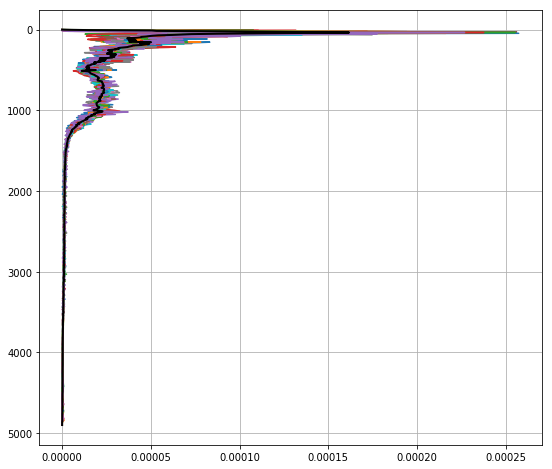

In [160]:
f, ax = plt.subplots()
for i in range(np.shape(N2)[1]):
    ax.plot(N2[:, i], grid)
ax.plot(np.nanmean(N2, axis=1), grid, color='k', linewidth=2)    
ax.invert_yaxis()
plot_pro(ax)

savee = 1
if savee > 0:
    my_dict = {'N2_avg': N2_avg, 'depth': grid, 'N2': N2,
               'gamma': sigma_avg_grid, 'CT': CT_avg_grid, 'SA': SA_avg_grid}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/ABACO_2017/background_profiles.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()


In [ ]:
avg_sig

In [121]:
# SG037 
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep_37))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep_37))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep_37))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep_37))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep_37))
for i in range(np.shape(avg_sig0_per_dep_37)[1]):  # loop over each profile
    dist_test = np.abs(dg_v_dist_37[i] - dist_grid)  # distance between this profile and every other on dist_grid
    closest_i = np.where(dist_test == dist_test.min())[0][0]  # find closest dist_grid station to this profile    
    
    # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
    # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
    this_sigma_avg = sigma_avg_grid[:, closest_i]
    eta_alt[:, i] = (avg_sig0_per_dep_37[:, i] - this_sigma_avg) / np.squeeze(ddz_avg_sigma[:, closest_i])
    d_anom_alt[:, i] = (avg_sig0_per_dep_37[:, i] - this_sigma_avg)        
            
    # ETA ALT 2
    # find appropriate average background profiles
    avg_a_salin = SA_avg_grid[:, closest_i]
    avg_c_temp = CT_avg_grid[:, closest_i]

    # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
    # eta_alt_2 is compute using a local reference pressure
    # loop over each bin depth
    for j in range(2, len(grid) - 2):
        if ~np.isnan(avg_sa_per_dep_37[j, i]):
            # profile density at depth j with local reference pressure (call p2)
            this_sigma = gsw.rho(avg_sa_per_dep_37[j, i], avg_ct_per_dep_37[j, i], grid_p[j]) - 1000      # profile density
            # background density at points above and below p2 with local reference pressure (p2)
            this_sigmat_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
            d_anom_alt[j, i] = this_sigma - this_sigmat_avg[1]
            gradient_alt[j, i] = np.nanmean(np.gradient(this_sigmat_avg, z[j-2:j+3]))
            eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    this_sigma_avg_e3 = this_sigma_avg[~np.isnan(this_sigma_avg)]
    grid_e3 = grid[~np.isnan(this_sigma_avg)]
    for j in range(len(grid_e3)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_avg_e3, avg_sig0_per_dep_37[j, i])
        if idx <= 2:
            z_rho_1 = grid_e3[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep_37[j, i], this_sigma_avg_e3[0:idx + 3], z_rho_1) - grid_e3[j]
        else:
            z_rho_1 = grid_e3[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep_37[j, i], this_sigma_avg_e3[idx - 2:idx + 3], z_rho_1) - grid_e3[j]

# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0_37 = eta_alt.copy()
eta_alt_2_37 = eta_alt_2.copy()
eta_alt_3_37 = eta_alt_3.copy()

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: Mean of empty slice


In [83]:
# SG038
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep_38))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep_38))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep_38))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep_38))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep_38))
for i in range(np.shape(avg_sig0_per_dep_38)[1]):  # loop over each profile
    dist_test = np.abs(dg_v_dist_38[i] - dist_grid)  # distance between this profile and every other on dist_grid
    closest_i = np.where(dist_test == dist_test.min())[0][0]  # find closest dist_grid station to this profile    
    
    # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
    # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
    this_sigma_avg = sigma_avg_grid[:, closest_i]
    eta_alt[:, i] = (avg_sig0_per_dep_38[:, i] - this_sigma_avg) / np.squeeze(ddz_avg_sigma[:, closest_i])
    d_anom_alt[:, i] = (avg_sig0_per_dep_38[:, i] - this_sigma_avg)        
            
    # ETA ALT 2
    # find appropriate average background profiles
    avg_a_salin = SA_avg_grid[:, closest_i]
    avg_c_temp = CT_avg_grid[:, closest_i]

    # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
    # eta_alt_2 is compute using a local reference pressure
    # loop over each bin depth
    for j in range(2, len(grid) - 2):
        if ~np.isnan(avg_sa_per_dep_38[j, i]):
            # profile density at depth j with local reference pressure (call p2)
            this_sigma = gsw.rho(avg_sa_per_dep_38[j, i], avg_ct_per_dep_38[j, i], grid_p[j]) - 1000      # profile density
            # background density at points above and below p2 with local reference pressure (p2)
            this_sigmat_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
            d_anom_alt[j, i] = this_sigma - this_sigmat_avg[1]
            gradient_alt[j, i] = np.nanmean(np.gradient(this_sigmat_avg, z[j-2:j+3]))
            eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    this_sigma_avg_e3 = this_sigma_avg[~np.isnan(this_sigma_avg)]
    grid_e3 = grid[~np.isnan(this_sigma_avg)]
    for j in range(len(grid_e3)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_avg_e3, avg_sig0_per_dep_38[j, i])
        if idx <= 2:
            z_rho_1 = grid_e3[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep_38[j, i], this_sigma_avg_e3[0:idx + 3], z_rho_1) - grid_e3[j]
        else:
            z_rho_1 = grid_e3[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep_38[j, i], this_sigma_avg_e3[idx - 2:idx + 3], z_rho_1) - grid_e3[j]

# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0_38 = eta_alt.copy()
eta_alt_2_38 = eta_alt_2.copy()
eta_alt_3_38 = eta_alt_3.copy()

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: Mean of empty slice


In [54]:
# ------- Mode Projections --------------
# define G grid 
omega = 0  # frequency zeroed for geostrophic modes
mmax = 40  # highest baroclinic mode to be calculated
nmodes = mmax + 1

G, Gz, c, epsilon = vertical_modes(N2_avg, grid, omega, mmax)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [145]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
Eta2 = eta_alt_3_37
V2 = dg_v_0_37
N_all = np.sqrt(N2_avg)

sz = np.shape(Eta2)
num_profs = sz[1]
eta_fit_depth_min = 250
eta_fit_depth_max = 4200  # 3900
AG = np.zeros([nmodes, num_profs])
AGz = np.zeros([nmodes, num_profs])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
V_m = np.nan * np.zeros([np.size(grid), num_profs])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
HKE_per_mass = np.nan * np.zeros([nmodes, num_profs])
modest = np.arange(11, nmodes)
good_ke_prof = np.ones(num_profs)
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5
for i in range(num_profs):
    # fit to velocity profiles
    this_V = V2[:, i].copy()
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz[:, i])))
        # Gz*AGz[:,i];
        HKE_per_mass[:, i] = (1 / 2) * (AGz[:, i] * AGz[:, i])
        ival = np.where(HKE_per_mass[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof[i] = 0  # flag profile as noisy
    else:
        good_ke_prof[i] = 0  # flag empty profile as noisy as well

    # fit to eta profiles
    this_eta = Eta2[:, i].copy()
    # obtain matrix of NEta
    Neta[:, i] = N_all * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))
    if len(iw[0]) > 1:
        eta_fs = Eta2[:, i].copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0][0]] / grid[iw[0][0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))
        eta_fs[i_dp[0]] = (grid[i_dp] - grid[-1]) * this_eta[iw[0][-1]] / (grid[iw[0][-1]] - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = N_all * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: overflow encountered in ushort_scalars
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in greater_equal
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater_equal


In [149]:
good_ke_prof

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.])

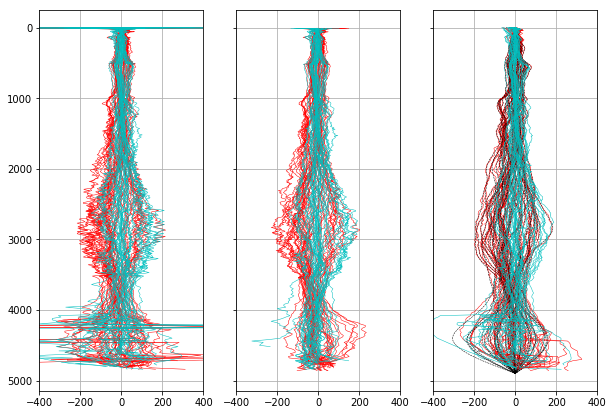

()

In [146]:
matplotlib.rcParams['figure.figsize'] = (10,7)
f, ax = plt.subplots(1, 3, sharey=True)
for i in range(np.shape(avg_sig0_per_dep_37)[1]):
    ax[0].plot(eta_alt_0_37[:, i], grid, linewidth=0.5, color='r')
    ax[1].plot(eta_alt_2_37[:, i], grid, linewidth=0.5, color='r')
    ax[2].plot(-1. * eta_alt_3_37[:, i], grid, linewidth=0.5, color='r')
    ax[2].plot(-1. * Eta_m[:, i], grid, linewidth=0.5, linestyle='--', color='k')
for i in range(np.shape(avg_sig0_per_dep_38)[1]):    
    ax[0].plot(eta_alt_0_38[:, i], grid, linewidth=0.5, color='c')
    ax[1].plot(eta_alt_2_38[:, i], grid, linewidth=0.5, color='c')
    ax[2].plot(-1 * eta_alt_3_38[:, i], grid, linewidth=0.5, color='c')
ax[0].set_xlim([-400, 400])
ax[0].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[1].set_xlim([-400, 400])
ax[2].set_xlim([-400, 400])
plot_pro(ax[2])

# f, ax = plt.subplots(1, 3, sharey=True)
# for i in range(lon.shape[1]):
#     ax[0].plot(eta_per_prof[:, i], grid, linewidth=0.6)
#     ax[2].plot(-1 * eta_per_prof_3[:, i], grid, linewidth=0.6)
# ax[0].set_xlim([-400, 400])
# ax[0].invert_yaxis()
# ax[0].grid()
# ax[2].set_xlim([-400, 400])
# plot_pro(ax[2])

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


Optimization terminated successfully.
         Current function value: 15849.743576
         Iterations: 10
         Function evaluations: 25
enstrophy dissipation length = [ 0.46746772]
RMS vorticity rossby no = [ 0.27552018]


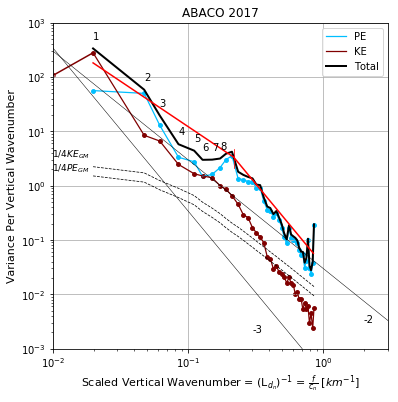

In [152]:
# --- find break for average profile (total energy) ---
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c[1]
sc_x = 1000 * f_ref / c[1:]
vert_wavenumber = f_ref / c[1:]
dk_ke = 1000 * f_ref / c[1]
PE_SD, PE_GM, GMPE, GMKE = PE_Tide_GM(1025.0, grid, nmodes, np.transpose(np.atleast_2d(N2_avg)), f_ref)
vert_wave = sc_x / 1000
alpha = 10
mu = 1.88e-3 / (1 + 0.03222 * np.nanmean(CT_avg_grid, axis=1) +
                0.002377 * np.nanmean(CT_avg_grid, axis=1) * np.nanmean(CT_avg_grid, axis=1))
nu = mu / gsw.rho(np.nanmean(SA_avg_grid, axis=1), np.nanmean(CT_avg_grid, axis=1), grid_p)
avg_nu = np.nanmean(nu)

PE_per_mass_0 = PE_per_mass[:, np.abs(dg_v_0_37[10, :]) < 0.75]
HKE_per_mass_0 = HKE_per_mass[:, np.abs(dg_v_0_37[10, :]) < 0.75]

matplotlib.rcParams['figure.figsize'] = (6,6)
scols = ['#00BFFF', '#800000']
f_s_en, ax = plt.subplots()
lw = [1.25, 1.25, 1.25, .8]
scz = [15, 15, 15, 6]
i = 0

TE_spectrum = (np.nanmean(PE_per_mass_0[1:, :], axis=1) / dk ) + (np.nanmean(HKE_per_mass_0[1:, :], axis=1) / dk)
in_sp = np.transpose(np.concatenate([sc_x[:, np.newaxis], TE_spectrum[:, np.newaxis]], axis=1))
start_g = sc_x[8]
min_sp_avg = fmin(spectrum_fit, start_g, args=(tuple(in_sp)))
this_TE = TE_spectrum 
x = np.log10(sc_x)
pe = np.log10(this_TE)
mid_p = np.log10(min_sp_avg)
l_b = np.nanmin(x)
r_b = np.nanmax(x)
x_grid = np.arange(l_b, r_b, 0.01)
pe_grid = np.interp(x_grid, x, pe)
first_over = np.where(x_grid > mid_p)[0][0]
s1 = -5 / 3
b1 = pe_grid[first_over] - s1 * x_grid[first_over]
fit_53 = np.polyval(np.array([s1, b1]), x_grid[0:first_over + 1])
s2 = -3
b2 = pe_grid[first_over] - s2 * x_grid[first_over]
fit_3 = np.polyval(np.array([s2, b2]), x_grid[first_over:])
fit_total = np.concatenate((fit_53[0:-1], fit_3))
# - closest mode number to ak0
# sc_x_break_i = np.where(sc_x < min_sp_avg)[0][-1]

# --- cascade rates (for average TE spectrum) ---
ak0 = min_sp_avg / 1000  # xx[ipoint] / 1000
E0 = np.interp(ak0 * 1000, sc_x, TE_spectrum)  # np.mean(yy_tot[ipoint - 3:ipoint + 4])
ak = vert_wave / ak0
one = E0 * ((ak ** (5 * alpha / 3)) * (1 + ak ** (4 * alpha / 3))) ** (-1 / alpha)
# ---  enstrophy/energy transfers
enst_xfer = (E0 * ak0 ** 3) ** (3 / 2)
ener_xfer = (E0 * ak0 ** (5 / 3)) ** (3 / 2)
enst_diss = np.sqrt(avg_nu) / (enst_xfer ** (1 / 6))
rms_vort = E0 * (ak0 **3) * (0.75*(1 - (sc_x[0] / 1000)/ak0)**(4/3) + np.log(enst_diss / ak0))
rms_ener = E0 * (ak0) * ( -3/2 + 3/2*( (ak0 ** (2/3))*((sc_x[0] / 1000) ** (-2/3))) - 
                         0.5 * (ak0 ** 2) * (enst_diss ** -2) + 0.5 * ak0 ** 4)
    
print('enstrophy dissipation length = ' + str(enst_diss))
print('RMS vorticity rossby no = ' + str(np.sqrt(rms_vort) / f_ref))
    
# plot 
ax.plot(sc_x, np.nanmean(PE_per_mass_0[1:, :], axis=1) / dk, color=scols[0], label='PE', linewidth=lw[i])
ax.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, :], axis=1) / dk, color=scols[0], s=scz[i])
ax.plot(sc_x, np.nanmean(HKE_per_mass_0[1:, :], axis=1) / dk, color=scols[1], label='KE', linewidth=lw[i])
ax.scatter(sc_x, np.nanmean(HKE_per_mass_0[1:, :], axis=1) / dk, color=scols[1], s=scz[i])
ax.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[:, :], axis=1)[0:2] / dk, color=scols[1], linewidth=1.5)
ax.scatter(10**-2, np.nanmean(HKE_per_mass_0[:, :], axis=1)[0] / dk, color=scols[1], s=scz[i]*1.5, facecolors='none') 
    
ax.plot(sc_x, (np.nanmean(PE_per_mass_0[1:, :], axis=1) + np.nanmean(HKE_per_mass_0[1:, :], axis=1)) / dk, 
            color='k', label='Total', linewidth=2)
    
ax.plot(10**x_grid, 10**fit_total, color='r')
ax.plot(10**np.array([x_grid[first_over], x_grid[first_over]]), 
            10**np.array([fit_3[0]-.2, fit_3[0]+.15]), color='r', linewidth=.75)
 
TEE = (np.nanmean(PE_per_mass_0[1:, :], axis=1) + np.nanmean(HKE_per_mass_0[1:, :], axis=1)) / dk    
modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
for j in range(len(modeno)):
    ax.text(sc_x[j], TEE[j] + (TEE[j]/2), modeno[j], color='k', fontsize=10)     
# -- GM
ax.plot(1000 * f_ref / c[1:], 0.25 * PE_GM / dk, color='k', linewidth=0.75, linestyle='--')
ax.text(1000 * f_ref / c[1] - .01, 0.4 * PE_GM[1] / dk, r'$1/4 PE_{GM}$', fontsize=9)
ax.plot(1000 * f_ref / c[1:], 0.25 * GMKE / dk, color='k', linewidth=0.75, linestyle='--')
ax.text(1000 * f_ref / c[1] - .01, 0.5 * GMKE[1] / dk, r'$1/4 KE_{GM}$', fontsize=9)    
ax.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax.text(2*10**0, 3*10**-3, '-2', fontsize=10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax.set_title('ABACO 2017')
ax.set_xlim([10 ** -2, 3 * 10 ** 0])
ax.set_xscale('log')

ax.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax.set_ylabel('Variance Per Vertical Wavenumber', fontsize=11)
ax.set_yscale('log')
plot_pro(ax)
f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/dg_abaco17_tot_energy.jpg", dpi=300)

In [153]:
ref_lat

26.5